In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import StatePreparation
from qiskit.circuit import Parameter
from scipy.optimize import minimize

# Wave Equation Simulation — Conceptual Overview

This notebook implements a quantum simulation of the **1D wave equation**, following the method developed in:

- *Quantum Algorithm for Simulating the Wave Equation* (Phys. Rev. A 2019)  
- *NISQ Simulation of the 1D Wave Equation* (2024)

The goal is to compare:

1. **Exact spectral evolution**  
   (a classical Fourier-based solver),
2. **Approximate quantum circuit evolution**  
   derived from **Eq. (14)** of the paper,

and evaluate how well the quantum circuit reproduces the true wave dynamics.

---

**The 1D Wave Equation**

The classical equation is:
$$
\partial_t^2 \psi(x,t) = \partial_x^2 \psi(x,t),
$$
on a periodic grid of
$$
N = 2^{n_{\mathrm{sys}}}
$$
points.

To obtain a unitary evolution suitable for a quantum computer, the equation is rewritten in first-order form:
$$
\partial_t
\begin{bmatrix}
\psi \\
\phi
\end{bmatrix}
=
\begin{bmatrix}
0 & I \\
D & 0
\end{bmatrix}
\begin{bmatrix}
\psi \\
\phi
\end{bmatrix},
$$
where:

- $\psi(x,t)$ is the displacement field,
- $\phi(x,t) = \partial_t\psi(x,t)$ is the velocity field,
- $D$ is the discrete Laplacian.

The corresponding time-evolution operator is:
$$
e^{-it\, Z_0 \otimes \sqrt{-D}}.
$$

A **control qubit** is introduced so that:

- control = $|0\rangle$ corresponds to $\psi$,
- control = $|1\rangle$ corresponds to $\phi$.

This embedding is the **Schrödingerization trick** that makes the system unitary.

---

**Why Fourier Methods are Essential**

In the **computational basis** $|x\rangle$:

- the Laplacian $D$ is dense and non-diagonal,
- $\sqrt{-D}$ is even more complicated,
- direct implementation is impossible on NISQ hardware.

However, in the **Fourier basis** $|k\rangle$:

- the eigenvectors of $D$ are plane waves,
- the eigenvalues are
  $$
  \lambda_k = -4\sin^2\!\left(\frac{\pi k}{N}\right),
  $$
- the wave frequencies are
  $$
  \omega_k = \sqrt{-\lambda_k}.
  $$

Thus the wave equation decouples into independent oscillators:
$$
e^{-i\omega_k t}
\qquad \text{and} \qquad
e^{+i\omega_k t}.
$$

This is why the algorithm surrounds the evolution block with **QFT$^\dagger$** and **QFT**:
$$
|x\rangle \xrightarrow{\text{IQFT}} |k\rangle,
\qquad\qquad
|k\rangle \xrightarrow{\text{QFT}} |x\rangle.
$$

---

**Structure of the \(|k\rangle\) Register**

After IQFT, the spatial register stores the momentum state:
$$
|k\rangle = |b_n\, b_{n-1}\,\dots\,b_1\rangle.
$$

- **Qubit 1 (first bit):** the **sign bit** → positive or negative mode  
- **Qubits 2…n:** **magnitude bits** → binary expansion of $|k|$

These bits determine the spectral phase applied by the evolution operator.

Additionally:

- the **control qubit** selects the $\pm\omega_k$ branch ($\psi$ vs $\phi$).

---

**The Ideal Propagator and Eq. (14)**

The ideal diagonal propagator is:
$$
e^{-it Z_0 \otimes \sqrt{-D}}
=
(H\otimes F)\,
\mathrm{diag}\bigl(e^{-it\omega_k},e^{+it\omega_k}\bigr)\,
(H\otimes F^\dagger),
$$
but the exact diagonal is not NISQ-friendly.

The paper derives **Eq. (14)**, a hardware-efficient approximation that:

- uses only **Rz** rotations and **ZZ interactions**,
- leverages the **binary structure** of $|k\rangle$,
- reproduces mode-by-mode oscillation through **binary-weighted phases**.

This results in:
$$
U(t)
\approx
e^{-it(2^{n-1}-1)\pi Z_0}
\left(
|0\rangle\langle 0|_1 + e^{itN\pi Z_0}|1\rangle\langle 1|_1
\right)
\prod_{q=2}^{n}
e^{it\,2^{\,n-q}\pi\, Z_0 Z_q}.
$$

Each magnitude bit contributes a rotation with weight $2^{\,n-q}$.  
This efficiently mimics the Fourier spectrum of the Laplacian.

---

**Full One-Step Quantum Evolution**

One timestep of the wave equation is implemented as:
$$
|\Phi(t)\rangle
=
(H\otimes\mathrm{QFT})\;
U_{\mathrm{eq14}}(t)\;
(H\otimes\mathrm{QFT}^\dagger)\,
|\Phi(0)\rangle.
$$

Steps:

1. Prepare the initial field $|g\rangle$.  
2. Apply **H** on control to mix $\psi/\phi$.  
3. Apply **IQFT** to enter momentum basis.  
4. Apply **Eq. (14)** hardware-efficient evolution.  
5. Apply **QFT** to return to spatial basis.  
6. Apply **H** on control to separate $\psi$ and $\phi$.  

This yields:
$$
|\Psi(t)\rangle
=
|0\rangle\otimes|\psi(t)\rangle
+
|1\rangle\otimes|\phi(t)\rangle.
$$

---

**Comparison Against the Exact Spectral Solver**

For validation, the notebook computes the exact classical evolution:
$$
\psi(x,t) = \sum_k
\left(
\psi_k^+ e^{-i\omega_k t} + \psi_k^- e^{+i\omega_k t}
\right)
e^{2\pi ikx/N}.
$$

This serves as the **ground truth** to evaluate the accuracy of the quantum circuit implementing Eq. (14).

---
**This project demonstrates:**

- how the wave equation can be embedded into a unitary system (**Schrödingerization**),
- how the Laplacian is diagonalized with **QFT/IQFT**,
- how **Eq. (14)** approximates the true spectral evolution using only NISQ-friendly gates,
- how $\psi$ and $\phi$ propagate through the control qubit,
- and how closely the quantum approximation matches the exact spectral solution.

This provides a complete, conceptually coherent foundation for analyzing quantum wave-equation simulation.


**Notebook structure.**  
The notebook is organized to mirror this conceptual flow:

0. **Parameters** – define the grid size $N = 2^{n_{\text{sys}}}$, time step(s), and physical / numerical constants.  
1. **Ricker wavelet $|g(x)\rangle$** – build the classical Ricker profile on the grid and prepare / train the PQC state $|g\rangle$.  
2. **QFT and IQFT (standard little-endian)** – implement the Fourier transforms that diagonalize the discrete Laplacian.  
3. **Time-evolution operator $U_{\text{eq14}}(t)$** – construct the Eq. (14) block using $R_z$ and ZZ gates.  
4. **“Exact” spectral propagator for comparison** – compute the classical reference solution $\psi(x,t)$ via the full spectral method.  
5. **Quick check: $|g\rangle$ vs. $g_x$** – verify that the prepared quantum state matches the target initial profile on the grid.  
6. **Full evolution: Eq. (14) circuit vs exact spectral** – simulate $U_{\text{eq14}}(t)$, extract $\psi(x,t)$ from the circuit, and compare it directly to the exact spectral solution.




# 0. Parameters


- $n_\text{sys}$ qubits → spatial grid representation  
- $+1$ **control qubit** → to separate the two physical fields in the wave equation  

So total qubits:

$$
n_\text{qubits} = n_\text{sys} + 1
$$

The spatial grid size is:

$$
N = 2^{n_\text{sys}}
$$

In [2]:
n_sys = 6                  # system qubits (spatial grid)
n_qubits = n_sys + 1       # total qubits = 1 control + n_sys system
N = 2**n_sys               # number of spatial grid points
times = [0.0, 0.3, 0.6, 0.9]
depth_PQC = int(np.floor(np.log2(n_sys+1))) + 1 

print(f"n_qubits = {n_qubits}, n_sys = {n_sys}, N = {N}, PQC depth = {depth_PQC}")

n_qubits = 7, n_sys = 6, N = 64, PQC depth = 3


# 1. Ricker wavelet |g(x)>

the continuous wavelet function need to efficiently encoded into the amplitude distribution over the computational basis.

The Ricker wavelet is a localized oscillatory function often used to represent a pulse:
$$
\psi(x, 0) = \left(1 - \frac{x^2}{\sigma^2}\right)e^{-x^2/(2\sigma^2)}
$$ They discretize this over $N = 2^{n_\text{sys}}$grid points, map $x_j \rightarrow j$, and normalize it to unit norm to be a valid quantum state.


In [3]:
def ricker_target_state(n_sys, mu=0.5, Sigma=0.1):
    """
    Normalized Ricker (Mexican hat) wavelet over grid x in [0,1).
    """
    N = 2**n_sys
    x = np.arange(N) / N
    g = ((2 / (np.sqrt(3 * Sigma * np.pi))) ** 0.5) \
        * (1 - ((x - mu) / Sigma) ** 2) \
        * np.exp(-((x - mu) ** 2) / (2 * Sigma ** 2))
    g = g.astype(complex)
    g /= np.linalg.norm(g)
    return g

Target_Ricker = ricker_target_state(n_sys)

# Prepare |g> on the system register (qubits 1..n_sys)
# state_prep = StatePreparation(Target_Ricker)
# len(Target_Ricker)

## Encoding (Initial State Preparation)

We want to encode the initial spatial field $\psi(x,0)$  
onto an $n_{\text{sys}}$-qubit register:

$$
|\Phi(0)\rangle
=
\sum_{j=0}^{N-1} \psi_j(0)\,|j\rangle,
\qquad
N = 2^{n_{\text{sys}}}.
$$

This is an **amplitude encoding** of the discretized function (e.g., a Ricker wavelet).

Because loading arbitrary amplitudes is exponentially expensive in general, the paper uses:

* a **shallow variational circuit** (brick-wall ansatz)  
* trained to approximate the target wavelet  

This provides an efficient, hardware-friendly approximation to the desired initial profile
$\psi(x,0)$.


## Parametrized Quantum Circuit (PQC)

The paper uses a **brickwall-style variational circuit** to approximate the initial field
$\psi(x,0)$ on $n_{\text{sys}}$ spatial qubits.

**(a) Brickwall Layout**

The PQC consists of $L$ layers, where each layer has **nearest-neighbor two-qubit blocks**
arranged in alternating patterns:

- layer 1: blocks on pairs $(0,1)$, $(2,3)$, $(4,5)$, …  
- layer 2: blocks on pairs $(1,2)$, $(3,4)$, $(5,6)$, …  
- layer 3: same as layer 1  
- … and so on.

Each block has its own set of learnable parameters
$$
\boldsymbol{\theta}^{(m)} = \bigl(\theta_1^{(m)}, \ldots, \theta_9^{(m)}\bigr).
$$

This means:

- **9 parameters per 2-qubit block**
- **number of blocks per layer ≈ $n_{\text{sys}}/2$**

**(b) Two-Qubit Block Structure (Generic SU(4)-like Gate)**

Each block $U^{(m)}$ is an efficiently parameterized universal 2-qubit gate.

A standard decomposition is:
$$
U^{(m)} =
\Bigl[
U_1\bigl(\theta_1^{(m)}, \theta_2^{(m)}, \theta_3^{(m)}\bigr)
\otimes
U_1\bigl(\theta_4^{(m)}, \theta_5^{(m)}, \theta_6^{(m)}\bigr)
\Bigr]\,
U_{\text{ent}}\bigl(\theta_7^{(m)},\theta_8^{(m)},\theta_9^{(m)}\bigr),
$$
where:

**Single-qubit part**

$$
U_1(\alpha,\beta,\gamma) = R_z(\alpha)\,R_y(\beta)\,R_z(\gamma)
$$

**Entangling part**

A convenient choice is:
$$
U_{\text{ent}}
=
\mathrm{CNOT}_{1\to 2}\,
R_z(\theta_7)\,
R_y(\theta_8)\,
\mathrm{CNOT}_{2\to 1}\,
R_y(\theta_9).
$$

This 9-parameter structure is expressive enough to approximate arbitrary 2-qubit unitaries efficiently.

**PQC Depth Formula (from the paper)**

For $n_{\text{sys}}$ system qubits:

- each brickwall layer uses $\lfloor n_{\text{sys}}/2 \rfloor$ two-qubit blocks  
- one layer only interacts disjoint pairs  
- depth alternates pairings to create full entanglement across the chain  

The paper states the depth as:

$$
\boxed{
L = \left\lfloor \log_2 (n_{\text{sys}} + 1) \right\rfloor + 1
}
$$

So:

- for $n_{\text{sys}} = 4$: $L = \lfloor\log_2(5)\rfloor + 1 = 2 + 1 = 3$  
- for $n_{\text{sys}} = 6$: $L = \lfloor\log_2(7)\rfloor + 1 = 2 + 1 = 3$  
- for $n_{\text{sys}} = 7$: $L = \lfloor\log_2(8)\rfloor + 1 = 3 + 1 = 4$  

This ensures:

- **sufficient expressivity**, while  
- keeping **depth logarithmic in the system size**, which is hardware-friendly.

In [4]:
# ================================================================
#  Full Brickwall PQC (3-CNOT entangling blocks, Fig. 5 in paper)
# ================================================================

# --- 1. Generic single-qubit unitary U1(α,β,γ) as a named gate
def U1_gate(a, b, c, label="U1"):
    sub = QuantumCircuit(1, name=label)
    sub.rz(a, 0)
    sub.ry(b, 0)
    sub.rz(c, 0)
    return sub.to_gate(label=label)


# --- 2. Three-CNOT entangling block as a named gate (matches Fig. 5 b)
#     Sequence: CNOT(0→1) → Rz(q0) → Ry(q1) → CNOT(1→0) → Ry(q1) → CNOT(0→1)
def entangling_block_gate(t7, t8, t9, label="Ent"):
    sub = QuantumCircuit(2, name=label)
    sub.cx(0, 1)        # first CNOT (q0→q1)
    sub.rz(t7, 0)       # Rz on control
    sub.ry(t8, 1)       # Ry on target
    sub.cx(1, 0)        # second CNOT (q1→q0)
    sub.ry(t9, 1)       # Ry on target again
    sub.cx(0, 1)        # third CNOT (q0→q1)
    return sub.to_gate(label=label)


# --- 3. Complete two-qubit block U^(m) as a named gate
#     2× pre-rotations, 3-CNOT entangler, 2× post-rotations → 15 parameters total
def two_qubit_block_gate(thetas, label="U^(m)"):
    """
    thetas = [θ1 ... θ15] (15 Parameter objects)
    """
    sub = QuantumCircuit(2, name=label)

    # Pre-rotations
    sub.append(U1_gate(thetas[0], thetas[1], thetas[2], label="U1_pre_q0"), [0])
    sub.append(U1_gate(thetas[3], thetas[4], thetas[5], label="U1_pre_q1"), [1])

    # Entangling section (3 CNOTs)
    sub.append(
        entangling_block_gate(
            thetas[6], thetas[7], thetas[8], label="Ent"
        ),
        [0, 1],
    )

    # Post-rotations
    sub.append(U1_gate(thetas[9],  thetas[10], thetas[11], label="U1_post_q0"), [0])
    sub.append(U1_gate(thetas[12], thetas[13], thetas[14], label="U1_post_q1"), [1])

    return sub.to_gate(label=label)


# --- 4. Assemble full brickwall PQC (Fig. 5 a), using named two-qubit blocks
def brickwall_PQC(n_qubits=4, depth=3):
    qc = QuantumCircuit(n_qubits)
    params = []
    param_index = 0

    for d in range(depth):
        # Alternate coupling pattern per layer: (0,1),(2,3) → (1,2) → repeat
        pairs = [(i, i + 1) for i in range(d % 2, n_qubits - 1, 2)]

        for (q0, q1) in pairs:
            # unique parameters for this two-qubit block
            thetas = [Parameter(f"θ{param_index + i}") for i in range(15)]
            params += thetas
            param_index += 15

            # Label block with layer + qubit pair, e.g. "U^0_(0,1)"
            block_label = f"U^{d}_({q0},{q1})"
            block_gate = two_qubit_block_gate(thetas, label=block_label)

            qc.append(block_gate, [q0, q1])

        # Optional: barrier between layers to visually separate them
        qc.barrier()

    return qc, params


## PQC Circuit Visualization Example 

Total parameters: 45


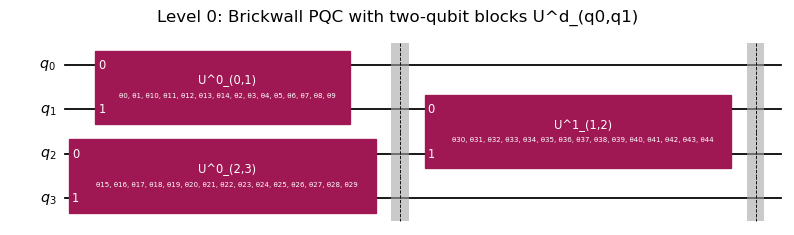

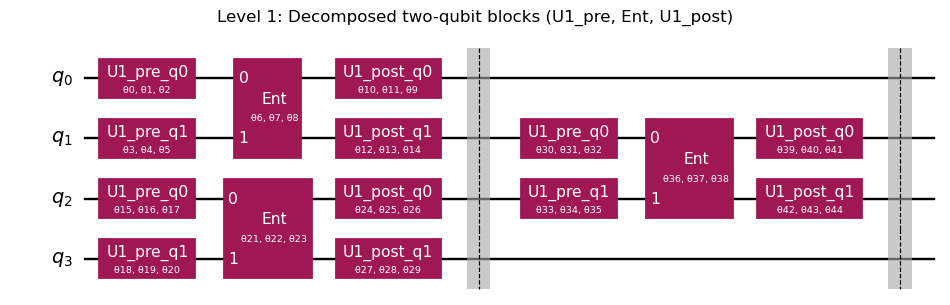

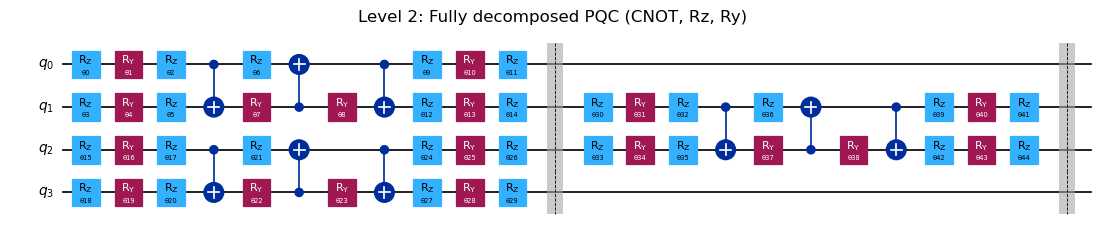

In [5]:
# --- 5. Example usage: visualize at different levels

# Build a 7-qubit, depth-2 brickwall circuit
qc_vis_PQC, params_vis_PQC = brickwall_PQC(n_qubits=4, depth=2)
print(f"Total parameters: {len(params_vis_PQC)}")  # should be 90 (6 blocks × 15 params)

# Level 0: high-level brickwall (each two-qubit block is one gate)
fig, ax = plt.subplots(figsize=(10, 3))
qc_vis_PQC.draw("mpl", ax=ax)
plt.title("Level 0: Brickwall PQC with two-qubit blocks U^d_(q0,q1)")
plt.show()

# Level 1: decompose one level (show pre/post U1's and Ent inside each block)
qc_L1 = qc_vis_PQC.decompose()  # decomposes the named two_qubit_block gates once
fig, ax = plt.subplots(figsize=(12, 4))
qc_L1.draw("mpl", ax=ax)
plt.title("Level 1: Decomposed two-qubit blocks (U1_pre, Ent, U1_post)")
plt.show()

# Level 2: decompose again (down to bare CNOTs and single-qubit rotations)
qc_L2 = qc_L1.decompose()  # decompose Ent and U1 gates
fig, ax = plt.subplots(figsize=(14, 5))
qc_L2.draw("mpl", ax=ax)
plt.title("Level 2: Fully decomposed PQC (CNOT, Rz, Ry)")
plt.show()


## Training the PQC to Learn the Ricker Wavelet

The PQC parameters $\boldsymbol{\theta}$ are chosen so that the prepared state

$$
|\psi(\boldsymbol{\theta})\rangle
=
U(\boldsymbol{\theta})\,|0\rangle^{\otimes n_{\text{sys}}}
$$

matches the target Ricker wavelet state $|g\rangle$.

This is achieved by minimizing the **fidelity-based cost function**:

$$
\boxed{
C(\boldsymbol{\theta})
=
1 - \mathrm{Re}\,\langle g \mid \psi(\boldsymbol{\theta}) \rangle
}
$$

where:

- $U(\boldsymbol{\theta})$ — the PQC  
- $|0\rangle^{\otimes n_{\text{sys}}}$ — initial all-zero computational basis state  
- $|g\rangle$ — target wavefunction encoded as a normalized vector  
- $|\psi(\boldsymbol{\theta})\rangle$ — PQC output state  
- $\langle g|\psi(\boldsymbol{\theta})\rangle$ — complex inner product (overlap) between the two states  

The cost takes values:

- $C = 0$ if the PQC perfectly reproduces $|g\rangle$  
- $C = 1$ if the PQC output is orthogonal to $|g\rangle$  

This is the quantum analogue of minimizing mean-squared error in classical ML, but performed in complex amplitude space.

**Optimization Algorithm**

The parameter vector $\boldsymbol{\theta}$ is optimized using **L-BFGS-B**, a quasi-Newton optimizer that is well suited for:

- smooth fidelity landscapes  
- moderate-dimensional parameter sets  
- variational quantum circuits  

The optimizer updates $\boldsymbol{\theta}$ iteratively until

$$
\mathrm{Re}\,\langle g|\psi(\boldsymbol{\theta})\rangle \;\to\; 1,
$$

yielding a PQC that prepares the desired spatial state with high fidelity.


In [6]:
# ================================================================
#  Brickwall PQC + Paper-Style Cost C(θ) + L-BFGS-B Training
# ================================================================

# ---------- Parameter binding (supports old/new Qiskit) ----------
def bind_params(qc, params, theta_vec):
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params)} # This line builds a dictionary mapping each symbolic parameter such as {Parameter('θ0'): 0.47, Parameter('θ1'): 0.12, ...}
    return qc.assign_parameters(bind_map) # injects the numerical values into the circuit. fully specified circuit 𝑈(𝜃)

def psi_from_thetas(qc_template, params, theta_vec):
    qc = bind_params(qc_template, params, theta_vec)
    sv = Statevector.from_instruction(qc) 
    return sv.data  # complex vector length 2^n , the complex amplitude vector of the prepared quantum state

# ---------- Paper-style cost: C(θ) = 1 - Re( <g| U(θ) |0...0> ) ----------
def make_cost(qc_template, params, g_vec):
    """function wrapper for cost calculation inside the minimizer"""
    def cost(theta_vec):
        psi = psi_from_thetas(qc_template, params, theta_vec)
        overlap = np.vdot(g_vec, psi)           # <g|ψ(θ)>
        return 1.0 - np.real(overlap)           # paper’s objective
    return cost

def cost(theta_vec):
    """One time cost calculation"""
    bind_map = {p: float(theta_vec[i]) for i, p in enumerate(params_PQC)}
    qc_bound = qc.assign_parameters(bind_map)
    psi = Statevector.from_instruction(qc_bound).data
    overlap = np.vdot(Target_Ricker, psi)         # <g|ψ(θ)>
    return 1.0 - np.real(overlap)     # paper's cost function

# (Optional) report fidelity and overlap nicely
def report(qc_template, params, theta_vec, g_vec):
    psi = psi_from_thetas(qc_template, params, theta_vec)
    overlap = np.vdot(g_vec, psi)
    fidelity = np.abs(overlap) ** 2
    cost_val = 1.0 - np.real(overlap)
    print(f"Final cost C(θ): {cost_val:.6f}")
    print(f"Re(<g|ψ>): {np.real(overlap):.6f},  Im(<g|ψ>): {np.imag(overlap):.6f}")
    print(f"Fidelity |<g|ψ>|^2: {fidelity:.6f}")

In [7]:
qc_PQC, params_PQC = brickwall_PQC(n_qubits=n_sys, depth=depth_PQC)
print(f"PQC built: {n_sys} qubits, depth {depth_PQC}, parameters: {len(params_PQC)}")


# initial θ sampled uniformly from [0,1] as in the paper
rng = np.random.default_rng(7)
theta0 = rng.uniform(0.0, 1.0, size=len(params_PQC))

# build cost
cost = make_cost(qc_PQC, params_PQC, Target_Ricker)

# optimize with L-BFGS-B (increase maxiter toward 100_000 if you want to mirror the paper)
res = minimize(
    cost,
    theta0,
    method="L-BFGS-B",
    options=dict(maxiter=600, ftol=1e-9, gtol=1e-8, maxcor=20, eps=1e-8)
)

print("\nOptimization status:", res.message)
print("Iterations:", res.nit)
print("Final cost:", res.fun)

theta_star_PQC = res.x
report(qc_PQC, params_PQC, theta_star_PQC, Target_Ricker)

# If you want the hardware-ready circuit with learned angles:
trained_qc_ricker = bind_params(qc_PQC, params_PQC, theta_star_PQC)
trained_qc_ricker.name = "Trained_PQC_ricker"

PQC built: 6 qubits, depth 3, parameters: 120

Optimization status: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Iterations: 114
Final cost: 0.02784888506683103
Final cost C(θ): 0.027849
Re(<g|ψ>): 0.972151,  Im(<g|ψ>): -0.000739
Fidelity |<g|ψ>|^2: 0.945078


## Ricker in Qunatum basis (PQC Result)

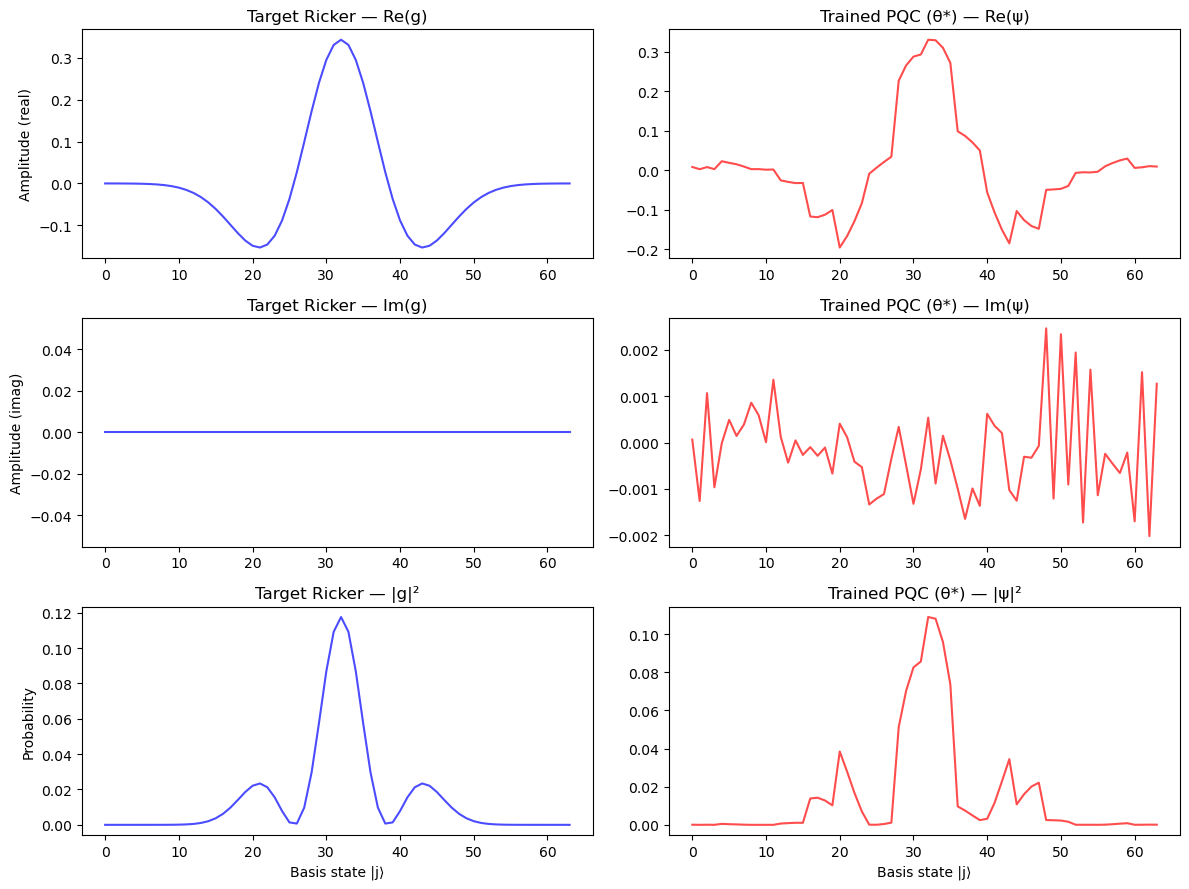

In [22]:
# ============================================================
#  Visualization: PQC at start (θ0), target, and trained (θ*)
# ============================================================

psi_trained_ricker = Statevector.from_instruction(trained_qc_ricker).data


# --- Prepare figure ---
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
x = np.arange(len(Target_Ricker))

# ===============================================
#  ROW 1 — Real part of amplitudes
# ===============================================
axs[0, 0].plot(x, Target_Ricker.real, color='blue', alpha=0.7)
axs[0, 0].set_title("Target Ricker — Re(g)")
axs[0, 0].set_ylabel("Amplitude (real)")

axs[0, 1].plot(x, psi_trained_ricker.real, color='red', alpha=0.7)
axs[0, 1].set_title("Trained PQC (θ*) — Re(ψ)")

# ===============================================
#  ROW 2 — Imaginary part of amplitudes
# ===============================================
axs[1, 0].plot(x, Target_Ricker.imag, color='blue', alpha=0.7)
axs[1, 0].set_title("Target Ricker — Im(g)")
axs[1, 0].set_ylabel("Amplitude (imag)")

axs[1, 1].plot(x, psi_trained_ricker.imag, color='red', alpha=0.7)
axs[1, 1].set_title("Trained PQC (θ*) — Im(ψ)")

# ===============================================
#  ROW 3 — Measurement probabilities |ψ|²
# ===============================================
axs[2, 0].plot(x, np.abs(Target_Ricker)**2, color='blue', alpha=0.7)
axs[2, 0].set_title("Target Ricker — |g|²")
axs[2, 0].set_xlabel("Basis state |j⟩")
axs[2, 0].set_ylabel("Probability")

axs[2, 1].plot(x, np.abs(psi_trained_ricker)**2, color='red', alpha=0.7)
axs[2, 1].set_title("Trained PQC (θ*) — |ψ|²")
axs[2, 1].set_xlabel("Basis state |j⟩")

# Improve layout and appearance
plt.tight_layout()
plt.show()

# 2. QFT and IQFT (standard little-endian)

The Quantum Fourier Transform (QFT) and its inverse (IQFT) play a central role in the algorithm:
they **diagonalize the discrete Laplacian operator**, exactly as FFTs do in classical spectral solvers
for PDEs.

This allows the wave equation’s time evolution operator \(e^{-it\, Z_0 \otimes \sqrt{-D}}\) to be
implemented efficiently using only phase and ZZ rotations.

**Why QFT is Needed**

The discrete Laplacian *is diagonal* in the Fourier basis.

Define the QFT (little-endian, as in Qiskit):
$$
F |x\rangle
=
\frac{1}{\sqrt{N}}
\sum_{k=0}^{N-1}
e^{2\pi i xk/N}\,|k\rangle.
$$

In this momentum basis the plane waves \(|k\rangle\) are the eigenvectors, and the eigenvalues are
$$
-4 \sin^2\!\left(\frac{\pi k}{N}\right).
$$

Thus:
$$
D = F^\dagger \Lambda F,
\qquad
\Lambda = \operatorname{diag}\!\Bigl(-4\sin^2\Bigl(\frac{\pi k}{N}\Bigr)\Bigr).
$$

Therefore:
$$
\sqrt{-D} = F^\dagger \sqrt{-\Lambda}\, F,
$$
and the wave-equation propagator becomes:
$$
e^{-it\,Z_0\otimes\sqrt{-D}}
=
(F^\dagger\otimes I)\,
e^{-it\, Z_0\otimes \mathrm{diag}(\omega_k)}\,
(F \otimes I),
$$
where
$$
\omega_k = \sqrt{-4\sin^2\left(\frac{\pi k}{N}\right)}.
$$

This is **exactly the quantum version of spectral methods** used in classical PDE solvers.

**Role of \(|k\rangle\) After IQFT**

After applying IQFT to the \(n_{\text{sys}}\) spatial qubits, the register is in a momentum basis
state \(|k\rangle\):
$$
|k\rangle = | b_{n}\, b_{n-1}\, \dots\, b_2\, b_1 \rangle.
$$

Qiskit uses **little-endian ordering**, so:

- \(b_1\) is the **least significant bit**  
- \(b_n\) is the most significant

But in the algorithm, these bits have **physical meaning**:

- Qubit 1 (just below control): the **SIGN BIT** Determines whether the Fourier mode corresponds to \(+k\)  (positive frequency) and \(-k\) (negative frequency). This is needed because FFT indexing wraps around at \(N/2\).

- Qubits 2…n: the **MAGNITUDE BITS** These determine the **strength** of the spectral phase applied during evolution. Binary expansion of the absolute momentum:
$$
k = (-1)^{b_1}
\sum_{q=2}^{n} b_q\,2^{\,n-q}.
$$ 


In [7]:
def qft_qiskit(n):
    qc = QuantumCircuit(n, name="QFT")
    for j in range(n):
        qc.h(j)
        for k in range(j+1, n):
            qc.cp(np.pi / 2**(k-j), k, j)
    return qc

def iqft_qiskit(n):
    qc = QuantumCircuit(n, name="IQFT")
    for j in reversed(range(n)):
        for k in reversed(range(j+1, n)):
            qc.cp(-np.pi / 2**(k-j), k, j)
        qc.h(j)
    return qc

## Circuit Visualization Example

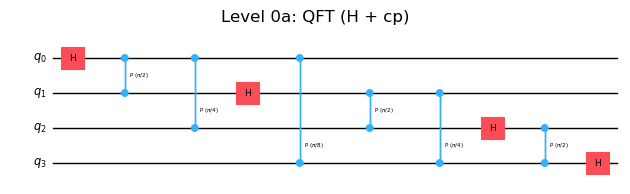

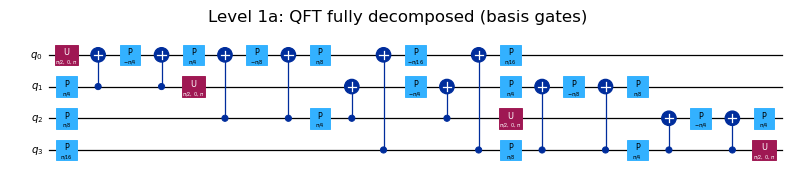

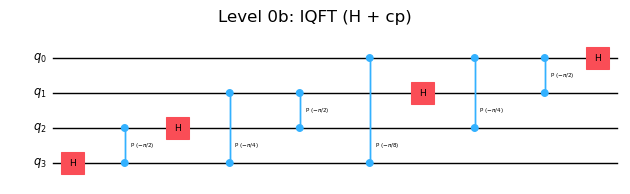

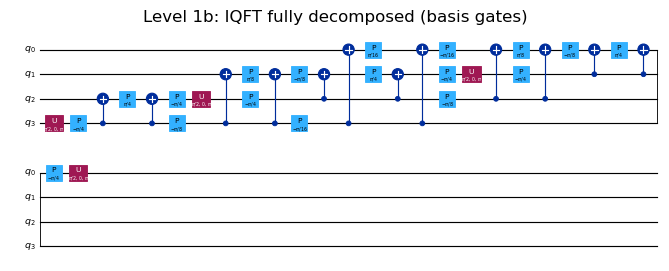

In [8]:
qft_sys_vis  = qft_qiskit(4)
iqft_sys_vis = iqft_qiskit(4)

# ---------------- QFT alone ----------------

# Level 0a: QFT as defined (H + cp)
fig, ax = plt.subplots(figsize=(8, 2))
qft_sys_vis.draw("mpl", ax=ax)
plt.title("Level 0a: QFT (H + cp)")
plt.show()

# Level 1a: QFT fully decomposed to basis gates
qft_sys_L1 = qft_sys_vis.decompose()
fig, ax = plt.subplots(figsize=(10, 3))
qft_sys_L1.draw("mpl", ax=ax)
plt.title("Level 1a: QFT fully decomposed (basis gates)")
plt.show()

# ---------------- IQFT alone ----------------

# Level 0b: IQFT as defined (H + cp)
fig, ax = plt.subplots(figsize=(8, 2))
iqft_sys_vis.draw("mpl", ax=ax)
plt.title("Level 0b: IQFT (H + cp)")
plt.show()

# Level 1b: IQFT fully decomposed to basis gates
iqft_sys_L1 = iqft_sys_vis.decompose()
fig, ax = plt.subplots(figsize=(10, 3))
iqft_sys_L1.draw("mpl", ax=ax)
plt.title("Level 1b: IQFT fully decomposed (basis gates)")
plt.show()

# 3. Time-evolution operator U_eq14(t)

After the system is transformed to the $|k\rangle$ (momentum) basis via $F^\dagger$:

- each Fourier mode oscillates independently with  
  $$\omega_k = \sqrt{-\lambda_k},$$
- and exact evolution is the simple phase  
  $$e^{-i \omega_k t}.$$

Eq. (14) provides a **hardware-amenable approximation** of these phases.

**Role of each qubit:**

- **Control qubit (q0)**  
  Selects between the $\psi$ and $\phi$ components.  
  (This is the Schrödingerization trick.)

- **Sign qubit (first bit of $|k\rangle$)**  
  Determines whether the frequency is positive or negative  
  → adds a $\pm$ phase or a wrap-around correction.

- **Magnitude bits**  
  Encode $|k|$ in binary  
  → determine the size of the phase rotation via binary weights $2^{\,n-q}$.

Together, these allow the circuit to emulate
$$
e^{-it Z_0 \otimes \sqrt{-D}}
$$
without needing exponentially many gates.

**Eq. (14): Hardware-Friendly Approximate Expansion**

The diagonal spectral operator is approximated as:
$$
\boxed{
U(t) \approx
e^{-it(2^{n-1}-1)\pi Z_0}
\Bigl(
|0\rangle\langle 0|_1 + e^{itN\pi Z_0}|1\rangle\langle 1|_1
\Bigr)
\prod_{q=2}^{n}
e^{it\,2^{\,n-q}\pi Z_0 Z_q}
}
$$

Breakdown of the components:

**(1) Global Z-rotation on the control qubit**

$$
e^{-it(2^{n-1}-1)\pi Z_0}
$$

Matches the lowest-frequency portion of the spectrum.

**(2) Sign-dependent phase**

$$
|0\rangle\langle 0|_1 + e^{itN\pi Z_0}|1\rangle\langle 1|_1
$$

- If qubit 1 is $|0\rangle$: positive $k$.  
- If qubit 1 is $|1\rangle$: negative $k$ → apply wrap-around correction.

**(3) Binary-weighted ZZ interactions**

$$
e^{it\,2^{\,n-q}\pi Z_0 Z_q}, \qquad q = 2,\ldots,n
$$

Each magnitude bit contributes:

- high-order bits → large rotations,  
- low-order bits → small rotations.

Implemented as:

CNOT(0 → q)
Rz(2 * θ_q) on qubit q
CNOT(0 → q)


**Angle Approximation**

The true spectrum
$$
\omega_k = \sqrt{-4 \sin^2\left(\frac{\pi k}{N}\right)}
$$
is approximated using the binary structure of \(k\):
$$
k = (-1)^s \sum_{q=2}^{n} b_q\, 2^{\,n-q}.
$$

This yields:
$$
\omega_k \approx \sum_{q=2}^{n} (-1)^s\, 2^{\,n-q}\pi,
$$
so the rotation angles become:
$$
\boxed{\theta_q(t) = 2^{\,n-q}\pi t.}
$$

Thus the ZZ rotations have **exponentially decaying magnitude** along the qubit chain.



In [9]:
def time_evolution_operator_eq14(t, n_qubits):
    """
    Implement Eq. (14) from the NISQ wave-equation paper.

    Qubit layout:
      - qubit 0 : control Z_0
      - qubit 1 : sign qubit
      - qubits 2..n_sys : magnitude bits

    n_sys = n_qubits - 1
    N = 2**n_sys
    """
    n_sys = n_qubits - 1
    N = 2**n_sys

    qc = QuantumCircuit(n_qubits, name=f"U_eq14(t={t})")

    # 1) Local phase: exp[-i t (2^{n-1} - 1) π Z0]
    alpha = (2**(n_sys - 1) - 1) * np.pi * t
    qc.rz(2 * alpha, 0)  # Rz(phi) = exp(-i phi Z/2)

    # 2) Sign-qubit block: |0><0|_1 + exp(i t N π Z0) |1><1|_1
    # Want exp(i β Z0) when sign qubit = 1, β = N π t.
    # Controlled-Rz(λ) on (control=1, target=0) gives exp(-i λ Z0/2).
    # So λ = -2β.
    beta = N * np.pi * t
    qc.crz(-2 * beta, 1, 0)

    # 3) ZZ couplings: Π_{q=2}^n exp(i t 2^{n-q} π Z0 Z_q)
    # Implement exp(i γ Z0 Z_q) as CX(0,q) Rz(-2γ)_q CX(0,q)
    for q in range(2, n_qubits):
        gamma_q = 2**(n_sys - q) * np.pi * t
        qc.cx(0, q)
        qc.rz(-2 * gamma_q, q)
        qc.cx(0, q)

    return qc

## Circuit Visualization Example

Eq.(14) circuit depth: 8


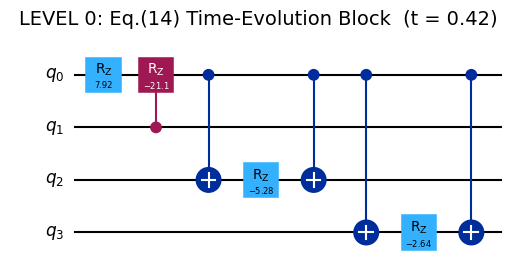

In [10]:
# ============================================================
# 0. Build the Eq.(14) circuit for visualization
# ============================================================

t_vis = 0.42                  # choose any time value
n_qubits_vis = 4              # 1 control + 6 system qubits (same as your experiment)
qc_eq14 = time_evolution_operator_eq14(t_vis, n_qubits_vis)

print("Eq.(14) circuit depth:", qc_eq14.depth())


# ============================================================
# 1. LEVEL 0 — High-level Eq.(14) block (named circuit)
# ============================================================
fig, ax = plt.subplots()
qc_eq14.draw("mpl", ax=ax)
plt.title(f"LEVEL 0: Eq.(14) Time-Evolution Block  (t = {t_vis})", fontsize=14)
plt.show()


# 4. "Exact" spectral propagator for comparison

To benchmark the quantum circuit, we compute the **exact classical evolution** of the wave equation using a full spectral (Fourier-based) solution.

In the Fourier basis, the discrete Laplacian is diagonal with eigenvalues
$$
\lambda_k = -4 N^2 \sin^2\left(\frac{\pi k}{N}\right),
$$
so each Fourier mode evolves independently with frequency
$$
\omega_k = \sqrt{-\lambda_k}.
$$

The exact propagator is therefore built by:

1. **Applying a Hadamard** on the control qubit (mixing $\psi$ and $\phi$).  
2. **Transforming to Fourier space**, where the Laplacian is diagonal.  
3. **Applying the exact phase factors**
   $$
   e^{-it\omega_k} \quad \text{and} \quad e^{+it\omega_k}
   $$
   to the $\psi$ and $\phi$ components.  
4. **Transforming back** to the spatial domain via inverse Fourier transform.

This produces the *true* time-evolved wavefunction $\psi(x,t)$, which we use as a **ground-truth reference** to evaluate the accuracy of the approximate quantum evolution (Eq. 14).


In [31]:
def fourier_matrix(N):
    k = np.arange(N)
    j = k[:, None]
    return np.exp(2j * np.pi * j * k / N) / np.sqrt(N)

F = fourier_matrix(N)
Fdag = F.conj().T

def spectral_propagator(t):
    """
    Build the 2N x 2N diagonal operator diag(e^{-it sqrt(-E_k)}, e^{+it sqrt(-E_k)}),
    as in the paper.
    """
    k = np.arange(N)
    Ek = -4 * N**2 * np.sin(np.pi * k / N)**2
    phases_pos = np.exp(-1j * t * np.sqrt(-Ek))  # top branch
    phases_neg = np.exp(+1j * t * np.sqrt(-Ek))  # bottom branch
    return np.diag(np.concatenate([phases_pos, phases_neg]))

def evolve_state_spectral(g_x, t):
    """
    Classical "exact" spectral evolution, analogue of Eq. (8).
    """
    # Embed |Φ(0)> = |0> ⊗ |g>  (second branch zero)
    Phi0 = np.zeros(2*N, dtype=complex)
    Phi0[:N] = g_x

    sv0 = Statevector(Phi0)

    H_top = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    H_top_big = np.kron(H_top, np.eye(N))

    U_diag = spectral_propagator(t)

    U = H_top_big @ np.kron(np.eye(2), F) @ U_diag @ np.kron(np.eye(2), Fdag) @ H_top_big

    evolved = sv0.evolve(Operator(U))
    amp = evolved.data.reshape(2, N)
    psi_t = amp[0]      # control = 0 branch
    return psi_t

# 5. Quick check: prepared initial |g> from Qiskit matches g_x

In [32]:
qc_init = QuantumCircuit(n_qubits)
qc_init.append(trained_qc_ricker, range(1, n_qubits))
sv_init = Statevector.from_instruction(qc_init)
psi_sys_init = sv_init.data[0::2]
print("Max diff between target g_x and prepared state:", np.max(np.abs(Target_Ricker - psi_sys_init)))

Max diff between target g_x and prepared state: 0.08669663023502516


# 6. Full evolution: Eq.(14) circuit vs exact spectral

The complete time-evolution step is:

$$
|\Phi(t)\rangle
=
(H \otimes F)\,
U_{\text{eq14}}(t)\,
(H \otimes F^\dagger)\,
|\Phi(0)\rangle.
$$

Operationally:

1. **Prepare** \(|g\rangle\)  
2. **H on control** → create \(\psi/\phi\) branches  
3. **IQFT** → to momentum basis \(|k\rangle\)  
4. **Apply Eq. (14)** (Rz + ZZ gates)  
5. **QFT** → back to \(|x\rangle\)  
6. **H on control** → recombine branches  

Result:

$$
|\Psi(t)\rangle
=
|0\rangle_0 \otimes |\psi(t)\rangle
+
|1\rangle_0 \otimes |\phi(t)\rangle.
$$

Full Circuit:
1. Prepare |g⟩ on system qubits
2. Apply H on control qubit
3. Apply IQFT on system  (F†)
4. Apply Eq.(14) block
5. Apply QFT on system   (F)
6. Apply H on control


**Decoding (Reading Out the Evolved State)**

After the wave-equation evolution, Schrödingerization produces the joint state:

$$
|\Psi(t)\rangle
=
|0\rangle_0 \otimes |\psi(t)\rangle
+
|1\rangle_0 \otimes |\phi(t)\rangle,
$$

where:

* $|\psi(t)\rangle$ = displacement field  
* $|\phi(t)\rangle$ = velocity field  
* qubit 0 is the **control qubit** introduced by the Schrödingerization trick  

This qubit determines **which physical quantity is encoded** in the spatial register:

* **control = $|0\rangle$** → spatial qubits store $\psi(x,t)$  
* **control = $|1\rangle$** → spatial qubits store $\phi(x,t)$  

When we examine the full statevector, Qiskit’s little-endian ordering makes this separation easy:

* **even indices** → control qubit is $|0\rangle$ → extract $\psi(x,t)$  
* **odd indices** → control qubit is $|1\rangle$ → extract $\phi(x,t)$  

Thus decoding is done by conditioning on the control qubit and discarding it, leaving the physical
field on the $n_{\text{sys}}$-qubit spatial register.

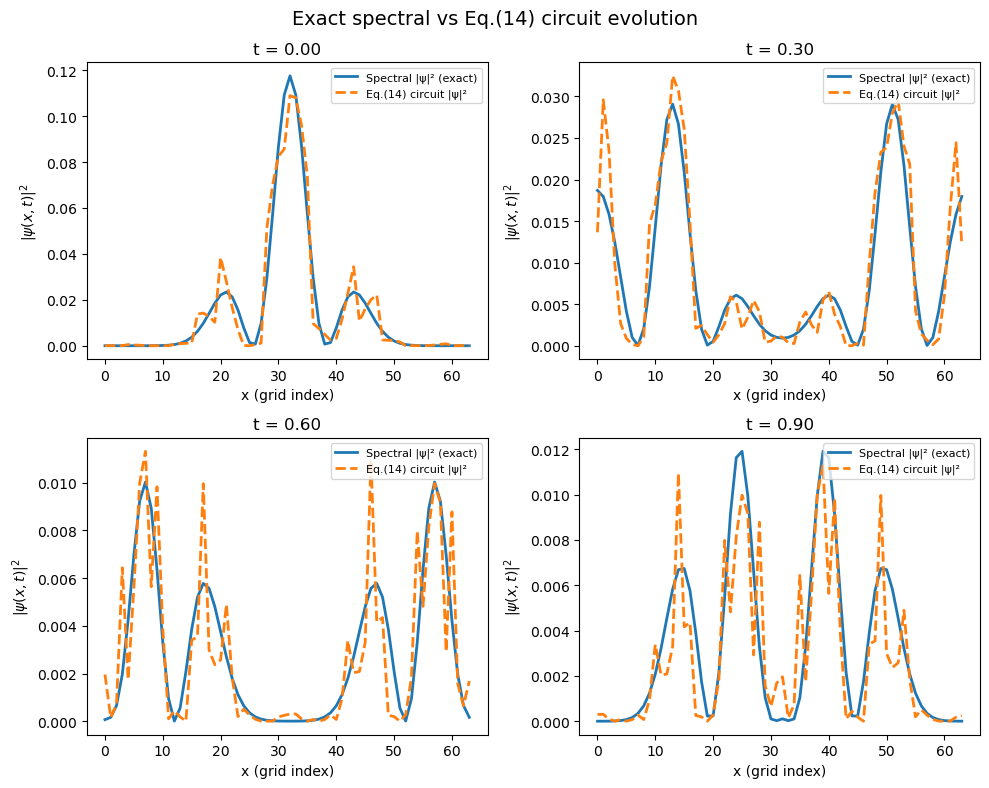

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, t in enumerate(times):
    qc = QuantumCircuit(n_qubits)

    # |Φ(0)> = |0> ⊗ |g>
    qc.append(trained_qc_ricker, range(1, n_qubits))

    # (H ⊗ QFT†)  — NOTE: IQFT BEFORE the diagonal
    qc.h(0)
    qc.append(iqft_qiskit(n_sys), range(1, n_qubits))

    # Diagonal time evolution block U_eq14(t)
    qc.append(time_evolution_operator_eq14(t, n_qubits), range(n_qubits))

    # (H ⊗ QFT) — QFT AFTER the diagonal, then H on control
    qc.append(qft_qiskit(n_sys), range(1, n_qubits))
    qc.h(0)

    # Noiseless simulation
    sv_t = Statevector.from_instruction(qc)
    psi_qiskit = np.array(sv_t)[0::2]      # control = 0 branch
    prob_qiskit = np.abs(psi_qiskit)**2

    # Exact spectral solution
    psi_spec = evolve_state_spectral(Target_Ricker, t)
    prob_spec = np.abs(psi_spec)**2

    ax = axes[i]
    ax.plot(prob_spec, label="Spectral |ψ|² (exact)", linewidth=2)
    ax.plot(prob_qiskit, "--", label="Eq.(14) circuit |ψ|²", linewidth=2)
    ax.set_title(f"t = {t:.2f}")
    ax.set_xlabel("x (grid index)")
    ax.set_ylabel(r"$|\psi(x,t)|^2$")
    ax.legend(loc="upper right", fontsize=8)

fig.suptitle("Exact spectral vs Eq.(14) circuit evolution", fontsize=14)
plt.tight_layout()
plt.show()

## Full Cicuit Visulization

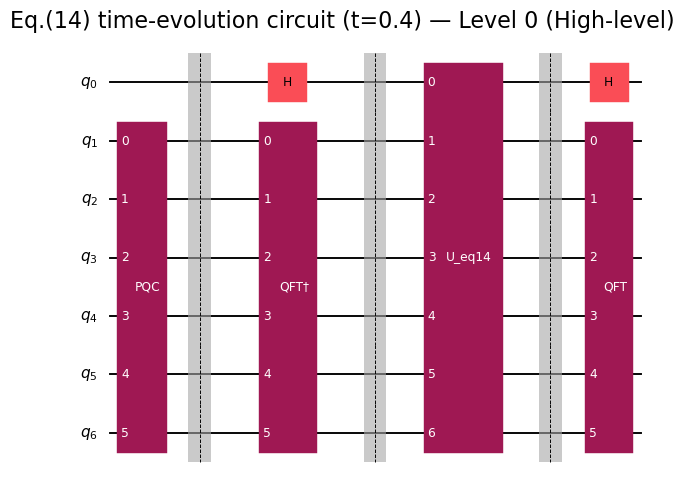

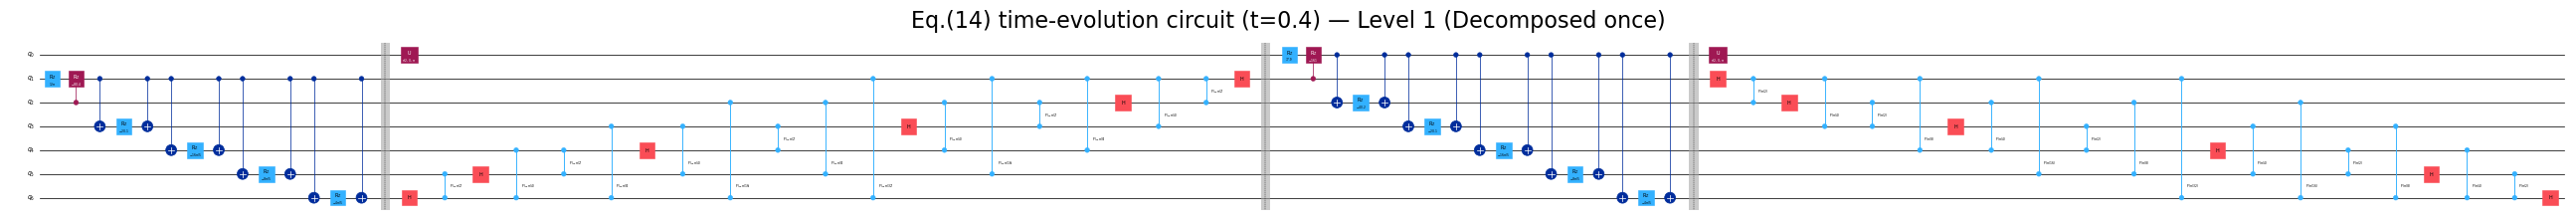

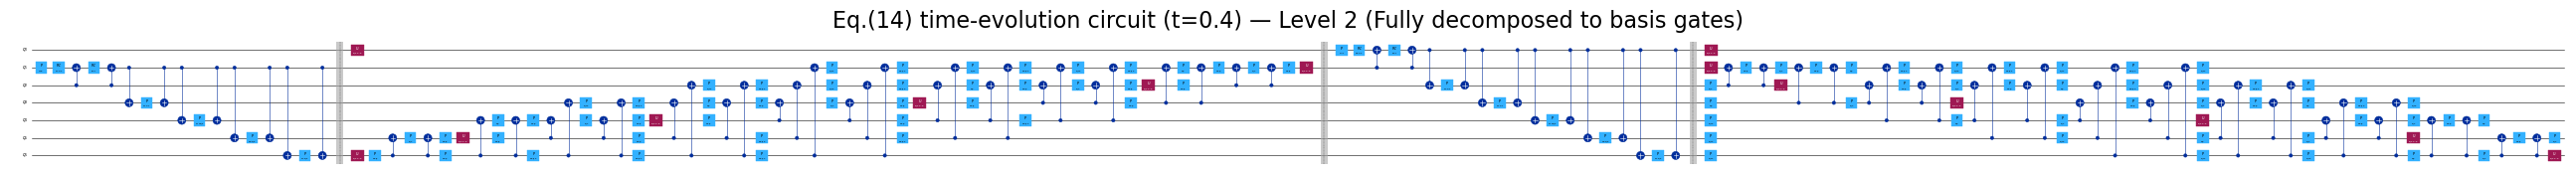

In [34]:
# -----------------------------------------------------------
# --- Gate wrappers with short labels -----------------------
# -----------------------------------------------------------

def pqc_gate(trained_qc_ricker):
    return trained_qc_ricker.to_gate(label="PQC")

def qft_gate(n_sys, qft_qiskit):
    return qft_qiskit(n_sys).to_gate(label="QFT")

def iqft_gate(n_sys, iqft_qiskit):
    return iqft_qiskit(n_sys).to_gate(label="QFT†")

def diag_gate(t, n_qubits, time_evolution_operator_eq14):
    return time_evolution_operator_eq14(t, n_qubits).to_gate(label="U_eq14")


# -----------------------------------------------------------
# --- Build the full circuit at time t ----------------------
# -----------------------------------------------------------

def build_full_eq14_circuit(t, n_qubits, n_sys,
                            trained_qc_ricker,
                            qft_qiskit,
                            iqft_qiskit,
                            time_evolution_operator_eq14):

    qc = QuantumCircuit(n_qubits, name="U(t)")

    # Pre-build gates with short labels
    G_pqc  = pqc_gate(trained_qc_ricker)
    G_qft  = qft_gate(n_sys, qft_qiskit)
    G_iqft = iqft_gate(n_sys, iqft_qiskit)
    G_diag = diag_gate(t, n_qubits, time_evolution_operator_eq14)

    # 1) Initial encoded state |Φ(0)> = |0> ⊗ |g>
    qc.append(G_pqc, range(1, n_qubits))
    qc.barrier()

    # 2) (H ⊗ IQFT)
    qc.h(0)
    qc.append(G_iqft, range(1, n_qubits))
    qc.barrier()

    # 3) Diagonal block: U_eq14(t)
    qc.append(G_diag, range(n_qubits))
    qc.barrier()

    # 4) (H ⊗ QFT)
    qc.append(G_qft, range(1, n_qubits))
    qc.h(0)

    return qc


# -----------------------------------------------------------
# --- Visualization helper ----------------------------------
# -----------------------------------------------------------

def visualize_circuit_multi_level(qc, title_prefix="Circuit"):
    """
    Produces three large standalone figures:
    - Level 0: High-level circuit
    - Level 1: Decomposed once
    - Level 2: Fully decomposed into basis gates
    """

    # ---------------- Level 0 ----------------
    fig, ax = plt.subplots()   # <<< BIGGER
    qc.draw("mpl", ax=ax, fold=-1) # <<< scale for bigger fonts/gates
    plt.title(f"{title_prefix} — Level 0 (High-level)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # ---------------- Level 1 ----------------
    qc_L1 = qc.decompose()
    fig, ax = plt.subplots(figsize=(26, 26))   # <<< EVEN BIGGER
    qc_L1.draw("mpl", ax=ax, fold=-1, scale=2)
    plt.title(f"{title_prefix} — Level 1 (Decomposed once)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # ---------------- Level 2 ----------------
    qc_L2 = qc.decompose().decompose()
    fig, ax = plt.subplots(figsize=(26, 10))  # <<< BIGGEST (long circuits)
    qc_L2.draw("mpl", ax=ax, fold=-1, scale=1.5)
    plt.title(f"{title_prefix} — Level 2 (Fully decomposed to basis gates)", fontsize=16)
    plt.tight_layout()
    plt.show()

    return qc_L1, qc_L2



# Example parameters (replace with your actual values)
t_test = 0.40
trained_qc_ricker1 = time_evolution_operator_eq14(t_test, n_sys)
# 1) Build circuit at time t
qc_full = build_full_eq14_circuit(
    t_test,
    n_qubits,
    n_sys,
    trained_qc_ricker1,
    qft_qiskit,
    iqft_qiskit,
    time_evolution_operator_eq14
)

# 2) Visualize entire circuit at all levels
qc_L1, qc_L2 = visualize_circuit_multi_level(qc_full,
                                             title_prefix=f"Eq.(14) time-evolution circuit (t={t_test})")